# EV_Adoption_Forecasting.ipynb

1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


 2. Load Data

In [2]:
df = pd.read_csv("Electric_Vehicle_Population_Size_History_By_County_.csv")
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


3. Data Cleaning

In [4]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Convert numeric columns from string with commas to integers
num_cols = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles'
]

for col in num_cols:
    df[col] = df[col].astype(str).str.replace(",", "").astype(int)

# Extract Year and Month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

 4. Handle Outliers

In [5]:
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Percent Electric Vehicles'] = np.clip(df['Percent Electric Vehicles'], lower_bound, upper_bound)


 5. Exploratory Data Analysis (EDA)

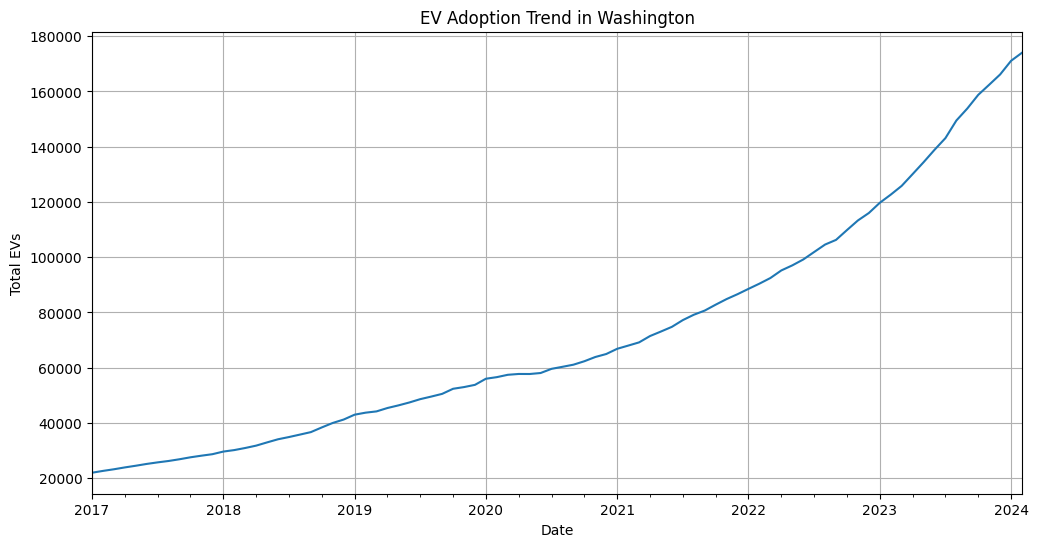

In [6]:
# EV growth over time
ev_trend = df.groupby('Date')['Electric Vehicle (EV) Total'].sum()
ev_trend.plot(figsize=(12, 6), title="EV Adoption Trend in Washington")
plt.xlabel("Date")
plt.ylabel("Total EVs")
plt.grid(True)
plt.show()

 6. Feature Engineering

In [7]:
# Label encoding
le_use = LabelEncoder()
le_county = LabelEncoder()

df['Vehicle_Use_Encoded'] = le_use.fit_transform(df['Vehicle Primary Use'])
df['County_Encoded'] = le_county.fit_transform(df['County'])

# Features and target
features = ['Year', 'Month', 'Vehicle_Use_Encoded', 'County_Encoded']
target = 'Electric Vehicle (EV) Total'

 7. Train-Test Split

In [8]:
# Time-based split
train = df[df['Date'] < '2023-01-01']
test = df[df['Date'] >= '2023-01-01']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

8. Train the Model

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

 9. Evaluate Model

In [10]:
y_pred = model.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 209.33547475094443
Root Mean Squared Error: 1670.4861575284037
R2 Score: 0.8823161559811804


 10. Forecast Future EV Adoption (2024–2026)

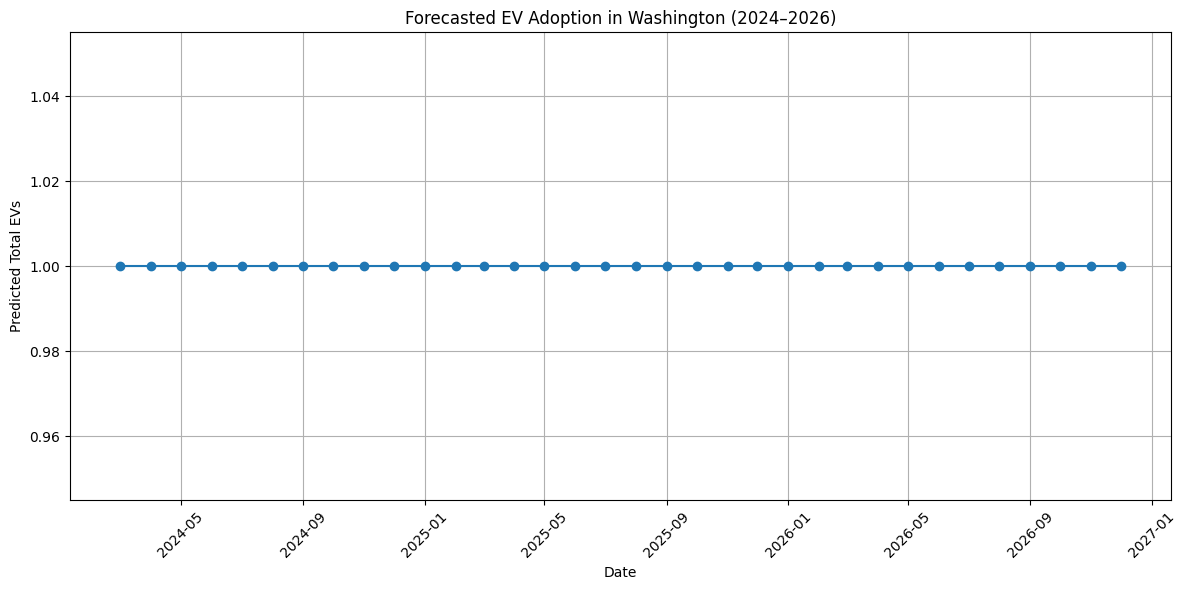

In [18]:
future_dates = pd.date_range(start='2024-03-01', end='2026-12-01', freq='MS')

future_df = pd.DataFrame({
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Vehicle_Use_Encoded': 0,  # Assuming Passenger
    'County_Encoded': 0        # Assuming average county
})

future_df['Predicted_EV_Total'] = model.predict(future_df)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_df['Predicted_EV_Total'], marker='o', linestyle='-')
plt.title("Forecasted EV Adoption in Washington (2024–2026)")
plt.xlabel("Date")
plt.ylabel("Predicted Total EVs")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()